In [107]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter 
import scipy.stats as stats 
import warnings
warnings.filterwarnings('ignore')
#sklearn utility 
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.utils import shuffle 
from sklearn.model_selection import RepeatedStratifiedKFold

## XGBoost 
from xgboost import XGBClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
import catboost as catboost 
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

### Reading the Data!
# Titanic Dataset 
titanic_train =pd.read_csv("./data/train.csv")
titanic_test=pd.read_csv("./data/test.csv")
dataset='titanic'
IDCol='PassergerID'
targetCol='Survived'
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [108]:
titanic_train.columns
titanic_train.dtypes
# titanic_train.nunique()
# titanic_train['Age'].head(100)

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [109]:
int_or_float=titanic_train.dtypes[titanic_train.dtypes.isin(['int64','float64'])].index
print(list(int_or_float))
num_cols=['Age','SibSp','Parch','Fare']
cat_cols=['Pclass','Sex','Embarked']

[]


In [110]:
trian_len=len(titanic_train)
combined=pd.concat(objs=[titanic_train,titanic_test],axis=0).reset_index(drop=True)
combined.tail()
combined.dtypes

PassengerId      int64
Survived       float64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [111]:
#missing Values

def missing_values_details(df):
    total =df.isnull().sum()
    missing_df=pd.DataFrame({'count_missing':total}).reset_index().rename(columns={'index':'column_name'})
    missing_df['percent_missing']=missing_df['count_missing']/len(df)
    missing_df=missing_df.sort_values(by='count_missing',ascending=False)
    missing_df=missing_df[missing_df['count_missing']!=0]
    print(f'Info: :{len(missing_df)} out of {len(df.columns)}columns have missing values')
    missing_90=missing_df[missing_df['percent_missing']>0.9]
    missing_80=missing_df[missing_df['percent_missing']>0.8]
    missing_70=missing_df[missing_df['percent_missing']>0.7]
    print(f'Info: :{len(missing_90)} columns have more that 90% missing values')
    print(f'Info: :{len(missing_80)} columns have more that 80% missing values')
    print(f'Info: :{len(missing_70)} columns have more that 70% missing values')
    return missing_df

missing_values_details(titanic_train)

Info: :3 out of 12columns have missing values
Info: :0 columns have more that 90% missing values
Info: :0 columns have more that 80% missing values
Info: :1 columns have more that 70% missing values


,column_name,count_missing,percent_missing
10,Cabin,687,0.771044
5,Age,177,0.198653
11,Embarked,2,0.002245


Info: There are 2 classes in the target column
Info: Maximum difference between 2 classes is 207 observations thath is 0.6052631578947368 times w.r.t. minimum class


0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

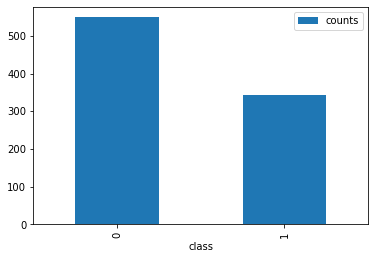

In [112]:
def check_class_balance(df, target_col):
    counts=df[target_col].value_counts()
    class_df=pd.DataFrame(counts).reset_index().rename(columns={target_col:'counts','index':'class'})
    class_df.plot.bar(x='class',y='counts')
    print(f'Info: There are {len(class_df)} classes in the target column')
    max_class=class_df['counts'].max()
    min_class=class_df['counts'].min()
    max_diff=max_class-min_class
    print(f'Info: Maximum difference between 2 classes is {max_diff} observations thath is {(max_diff/min_class)} times w.r.t. minimum class')
    return class_df


check_class_balance(titanic_train,'Survived')
titanic_train['Survived']


In [113]:
#outliers 

def detect_outliers(df,n,features):
    outlier_indices=[]
    # iterate over features (columns)

    for col in features:
        Q1=np.percentile(df[col],25)
        Q3=np.percentile(df[col],75)
        IQR= Q3-Q1

        outlier_step=1.5*IQR
        outlier_list_col=df[(df[col]<Q1-outlier_step)|(df[col]>Q3+outlier_step) ].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices=Counter(outlier_indices)
    multiple_outliers=list(k for k, v in outlier_indices.items() if v >n)

    return multiple_outliers
#detect outliers form num_cols

outliers_rows=detect_outliers(titanic_train,2,num_cols)
print(len(outliers_rows))
#Drop outliers
titanic_train=titanic_train.drop(outliers_rows,axis=0).reset_index(drop=True)


10


In [114]:
def describe_num_col(train,col):
    count_train=train[col].isnull().sum()
    train_k=stats.kurtosis(train[col].dropna(),bias=False)
    train_s=stats.skew(train[col].dropna(),bias=False)
    ### Outliers

    def count_outliers(df,col):
        mean_d=np.mean(df[col])
        std_d=np.std(df[col])
        scaled=(df[col]-mean_d)/std_d
        outliers=abs(scaled)>3
        if len(outliers.value_counts())>1:
            return outliers.value_counts()[1]
        else:
            return 0
    train_o=count_outliers(train,col)
    summ_def=pd.DataFrame({'info':['missing_count', 'missing_percent', 'skewness', 'kurtosis', 'outlier_count', 'outlier_percent'],
                           'train_set':[count_train, (count_train/len(train))*100, train_s, train_k, train_o, (train_o/len(train))*100]})
    fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(10,6))
    plot10 = sns.distplot(train[train['Survived']==0][col],ax=ax1, label='Not Survived')
    sns.distplot(train[train['Survived']==1][col],ax=ax1,color='red', label='Survived')
    plot10.axes.legend()
    ax1.set_title(f'Distrubution of {col}')
    sns.boxplot(x='Survived',y=col,data=train, ax=ax2)
    ax2.set_xlabel('Category')
    ax2.set_title(f'Boxplot of {col}')

    fig.show()

    return 

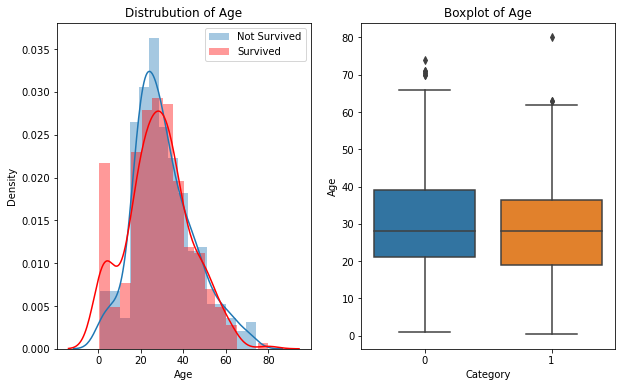

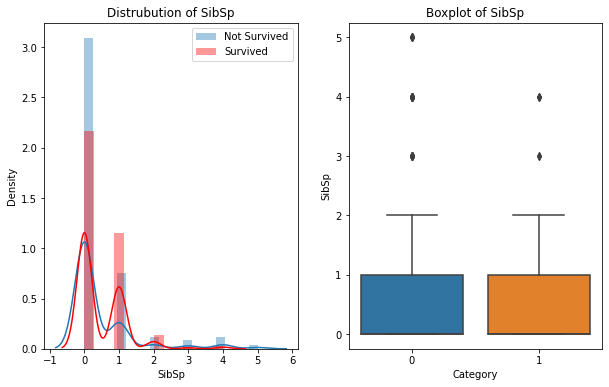

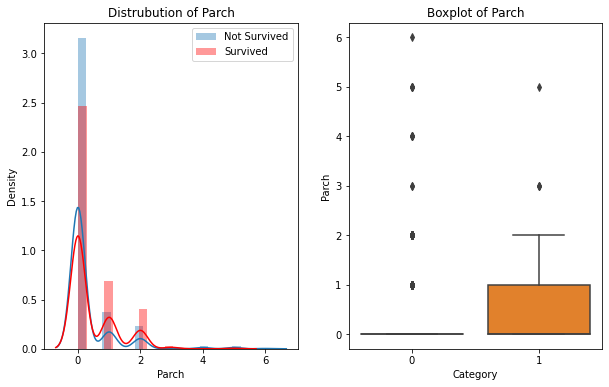

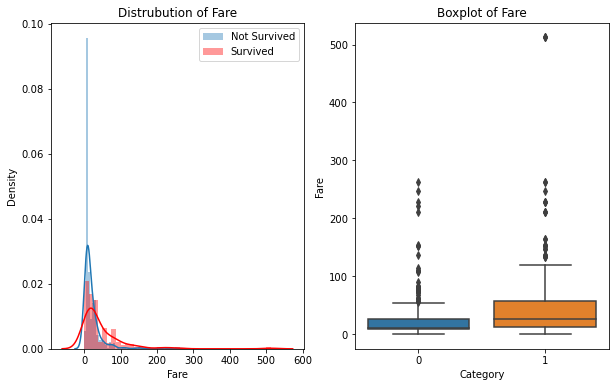

In [115]:
for col in num_cols:
    describe_num_col(titanic_train,col)

In [116]:
### the column Fare is continuous and it is right skewed 
# apply log tranformation to Fare to reduce skewness distribution
combined['Fare']=combined['Fare'].map(lambda x : np.log(x) if x>0 else 0)

In [117]:
### Catrgorical Columns 
def describe_cat_col(df, col):
    ##3 unique values
    count_u = df[col].nunique()
    nulls =df[col].isnull().sum()

    ### Percent share df 
    share_df= pd.DataFrame(df[col].value_counts()).reset_index().rename(columns={'index':'class_name',col:'counts'})
    share_df['percent_share']=share_df['counts']/sum(share_df['counts'])
    share_df=share_df.sort_values(by='percent_share', ascending=False)

    # display(share_df)

    if(count_u>3 and count_u<10):
        fig, ax= plt.subplots()
        fig.suptitle(col+'Distribution', color='red')
        explode = list((np.array(list(df[col].dropna().value_counts()))/sum(list(df[col].dropna().value_counts())))[::-1])
        labels=list(df[col].dropna().unique())
        sizes=df[col].value_counts()
        ax.pie(sizes, explode=explode, startangle=60,labels=labels, autopct='%1.0f%%',pctdistance=0.9)
        ax.add_artist(plt.Circle((0,0),0.2,fc='white'))
        plt.show()
    else:
        plt.figure()
        plt.title(col+'Distribution',color='red')
        sns.barplot(x=col, y='Survived', data=df)
        plt.show()
    return
        


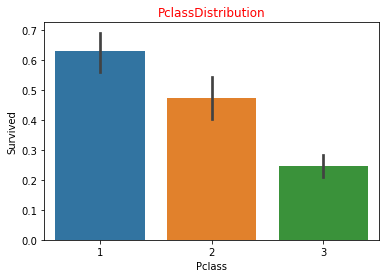

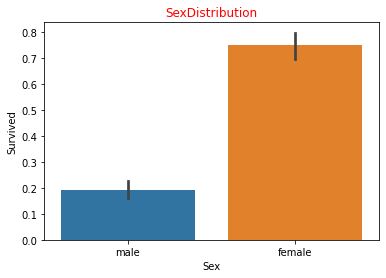

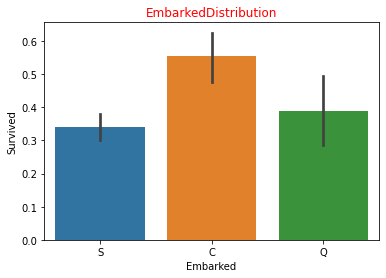

In [118]:
for col in cat_cols:
    describe_cat_col(titanic_train, col)

In [119]:
### Filling the missing values 
combined['Embarked']=combined['Embarked'].fillna(combined['Embarked'].value_counts().index[0])
combined['Embarked'].isnull().sum()


0

In [120]:
combined=pd.get_dummies(combined,columns=['Embarked'],prefix="Em")

In [121]:
combined['Sex']=combined['Sex'].map({'male':0,'female':1})
#filling missing value of Age

##fill age with the median age of similar rows according to pclass, parch and sibsp 
# index of Nan age rows
index_NaN_age=list(combined['Age'][combined["Age"].isnull()].index)

for i in index_NaN_age:
    age_med=combined['Age'].median()
    age_pred=combined['Age'][((combined['SibSp']==combined.iloc[i]['SibSp'])& (combined['Parch']==combined.iloc[i]['Parch'])&(combined['Pclass']==combined.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred):
        combined['Age'].iloc[i]=age_pred
    else:
        combined["Age"].iloc[i]=age_med

In [122]:
combined["Cabin"].describe()

count             295
unique            186
top       C23 C25 C27
freq                6
Name: Cabin, dtype: object

In [123]:
# Replace the Cabin number by the typeof cabin 'X' if not
combined['Cabin']=pd.Series([i[0] if not pd.isnull(i) else 'X' for i in combined['Cabin']])
combined["Cabin"]=pd.get_dummies(combined,columns=['Cabin'],prefix="Cabin")


In [124]:
### Feature Transformation 
#### Name-> Title

# Get Title from Name
combined_title=[i.split(",")[1].split(".")[0].strip() for i in combined["Name"]]
combined['Title']=pd.Series(combined_title)
combined['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

In [126]:
# Convert to categorical values Title
combined["Title"] = combined["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
combined["Title"] = combined["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
combined["Title"] = combined["Title"].astype(int)

ValueError: Cannot convert non-finite values (NA or inf) to integer